In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import seaborn as sns
from scipy.stats import powerlaw, norm, t, cauchy, pareto, gamma, lognorm
from sklearn.linear_model import LinearRegression, HuberRegressor
import sys
import yfinance as yf

sys.path.append('../')
from src.stats import *
from src.distributions import SimpleNormalMixture, UnivariateVarianceGamma

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
sns.set_style('darkgrid')

%matplotlib inline

# 4.1 A simple heuristic to create mildly fat tails

## Figure 4.1: A simple normal mixture distribution

The notations in Figure 4.1 are not clear. Let me clarify the ideas. 

Let us consider the pdf of a normal distribution with zero mean as a function of variance $s$
$$
s\rightarrow f(s, x) = \frac{1}{\sqrt{2\pi s}}\exp{(-\frac{x^2}{2s})}
$$
For large $x$, $f(s, x)$ is a convex function of $s$, therefore we have
$$
\frac{1}{2} f(s, x) = \frac{1}{2}f(((1-a)+(1+a))s, x) \leq \frac{1}{2}(f((1-a)s, x) + f((1+a)s, x))
$$
where $\frac{1}{2}(f((1-a)s, x) + f((1+a)s, x))$ is the pdf of $XY$ where $X$ is a normal rv with variance $s$ and $Y$ is an independent binomial random variable with $P(Y=\sqrt{1-a})=P(Y=\sqrt{1+a})=1/2$. The variance of $XY$ is 
$$
E[X^2Y^2] = E[Y^2]s = \frac{1}{2}((1-a)+(1+a))s = s
$$


### Plot PDFs, i.e. f(s, x) as a function of x

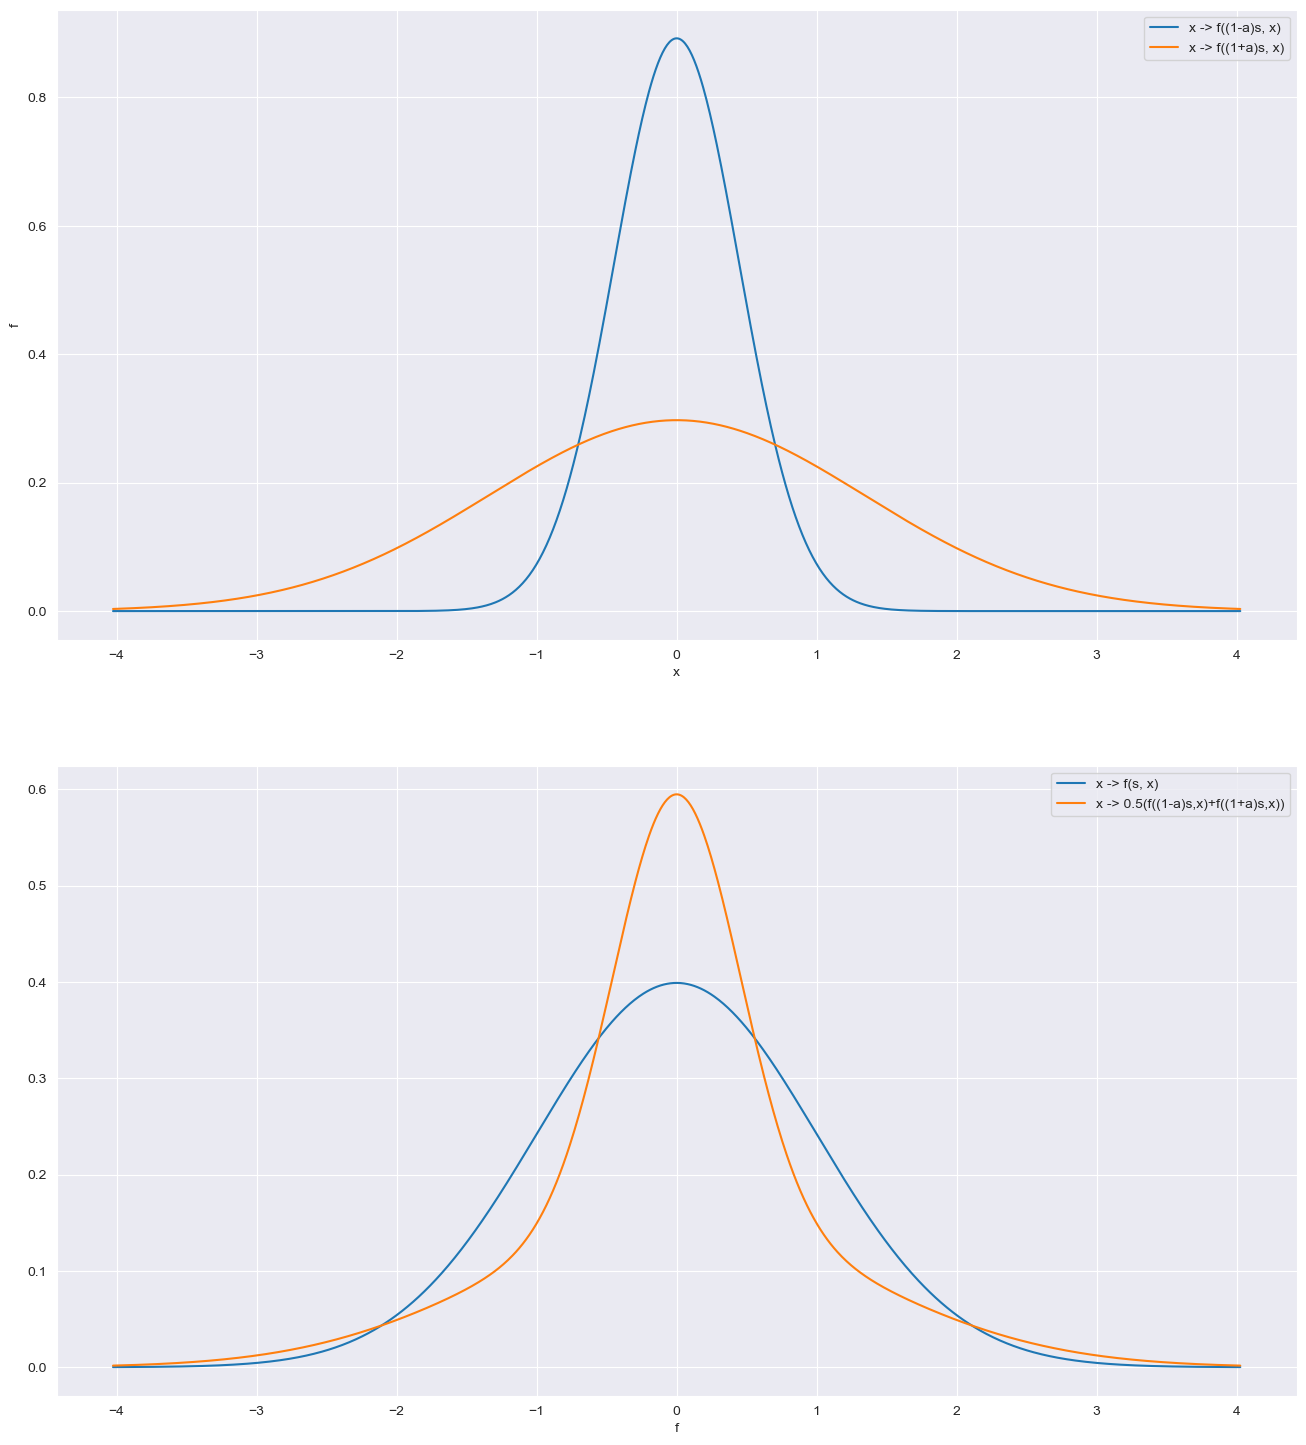

In [2]:
# Set values of x, a, s
m = 0
s = 1
a = 0.8
x = np.linspace(-3*np.sqrt(1+a), 3*np.sqrt(1+a), 1000)

snm = SimpleNormalMixture(m, s, a)

# Plot the PDFs of the simple normal mixture distribution
fig, axs = plt.subplots(2, 1, figsize=(16, 18))

axs[0].plot(x, norm.pdf(x, m, np.sqrt(1-a)*s), label='x -> f((1-a)s, x)')
axs[0].plot(x, norm.pdf(x, m, np.sqrt(1+a)*s), label='x -> f((1+a)s, x)')
axs[0].set_xlabel('x')
axs[0].set_ylabel('f')
axs[0].legend()

axs[1].plot(x, norm.pdf(x, m, s), label='x -> f(s, x)')
axs[1].plot(x, snm.pdf(x), label='x -> 0.5(f((1-a)s,x)+f((1+a)s,x))')
axs[1].set_xlabel('x')
axs[1].set_xlabel('f')
axs[1].legend()

### Plot f(s, x) as a function of s

Text(0, 0.5, 'f')

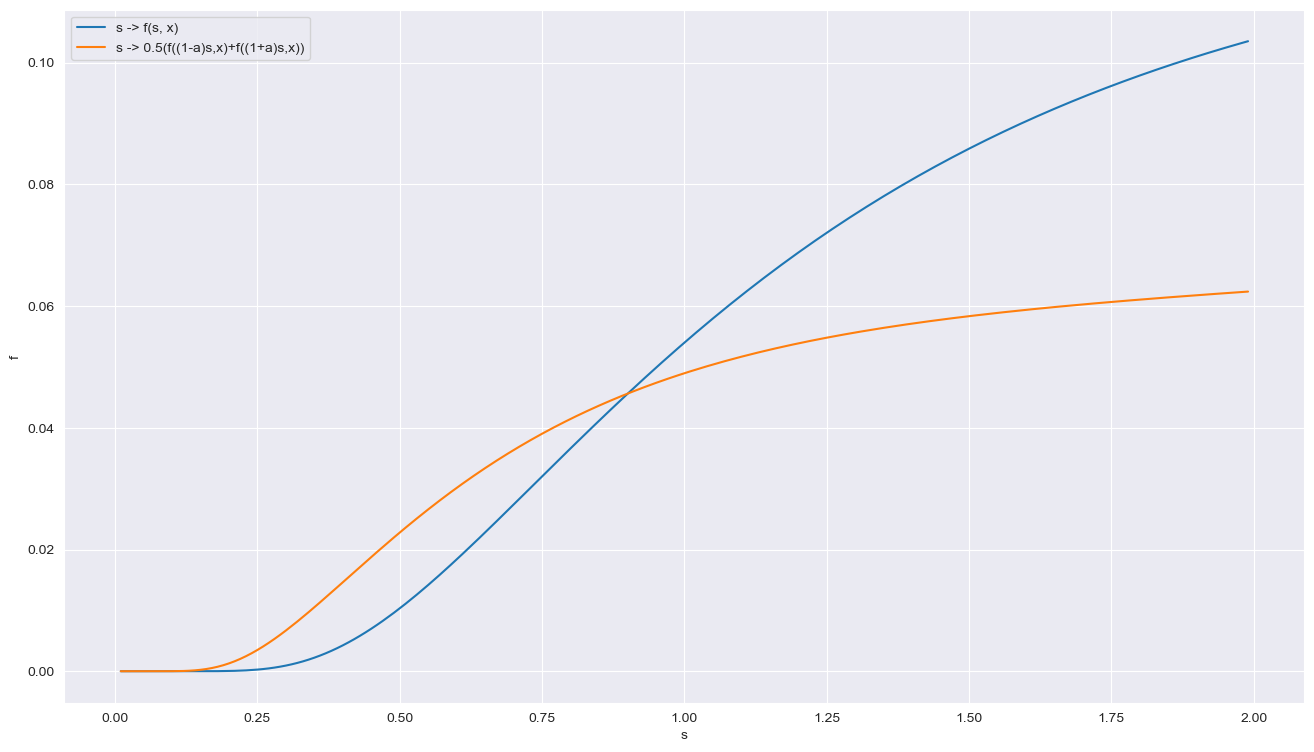

In [3]:
# Set values of x, a, s
s = np.arange(0.01, 2, 0.01)
a = 0.8
x = 2

# Simple normal pdf as a function of s
def func(s, x):
    return norm.pdf(x, scale=np.sqrt(s))

# Figure that compares the functions
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(s, func(s, x), label='s -> f(s, x)')
ax.plot(s, 0.5*(func((1-a)*s, x)+func((1+a)*s, x)), label='s -> 0.5(f((1-a)s,x)+f((1+a)s,x))')
ax.legend()
ax.set_xlabel('s')
ax.set_ylabel('f')

## Figure 4.2: Stochastic Variance: Gamma distribution and Lognormal of same mean and variance.

Note: I believe that the parameterization $gamma(k,\theta)$ in the figures is from [wiki](https://en.wikipedia.org/wiki/Gamma_distribution). The paramterization $(\alpha, V)$ in the text corresponds to $V=k\theta$ and $a=k$.

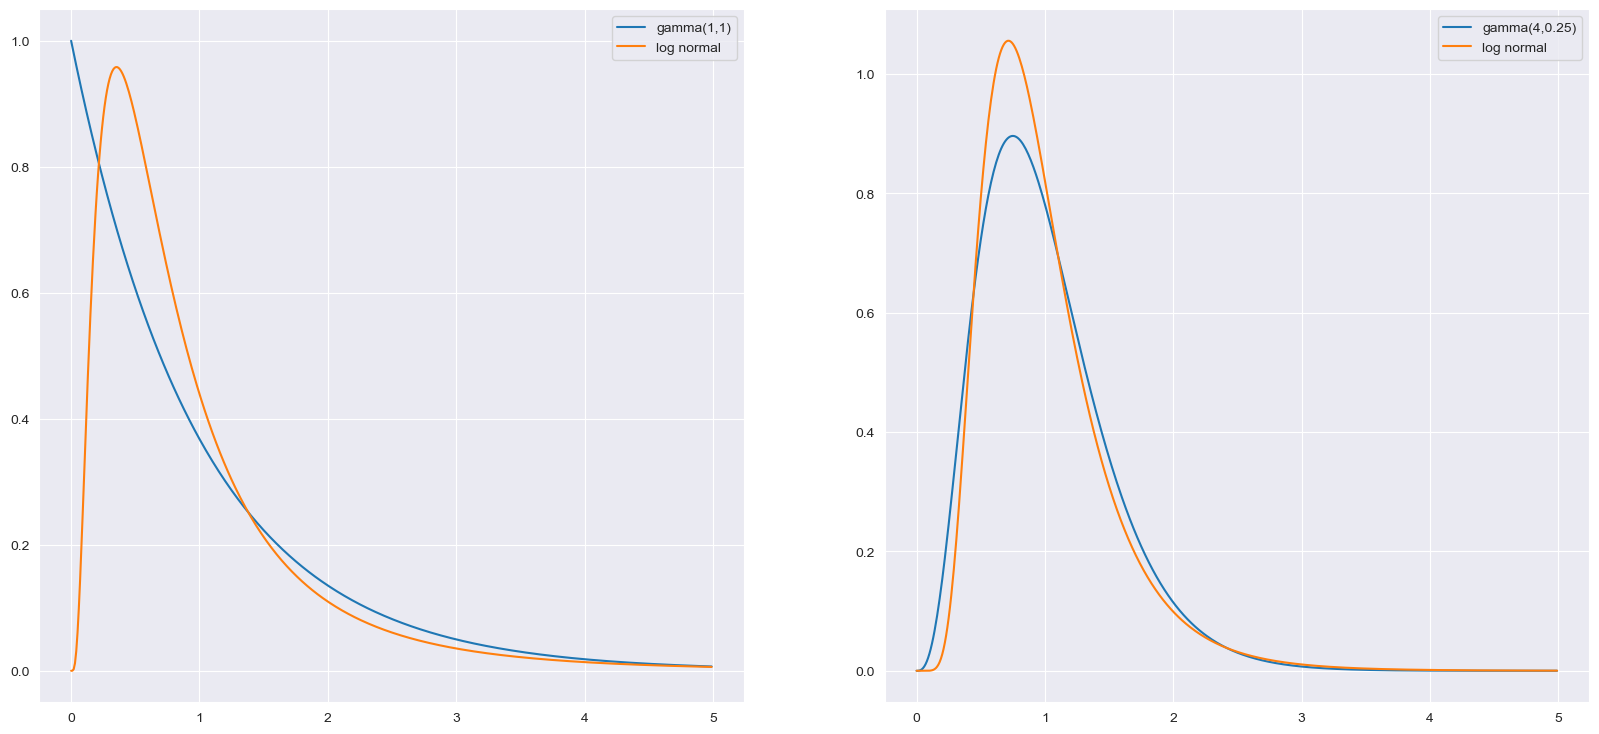

In [4]:
x = np.arange(0, 5, 0.01)

fig, axs = plt.subplots(1, 2, figsize=(20, 9))

# Gamma parameters
k = 1
theta = 1
gamma_mean = gamma.mean(k, loc=0, scale=theta)
gamma_var = gamma.var(k, loc=0, scale=theta)

# Parameters for log-normal distribution
mu, sigma = lognorm_params_from_mean_and_variance(gamma_mean, gamma_var)

axs[0].plot(x, gamma.pdf(x, k, loc=0, scale=theta), label='gamma({},{})'.format(str(k),str(theta)))
axs[0].plot(x, lognorm.pdf(x, sigma, loc=0, scale=np.exp(mu)), label='log normal')
axs[0].legend()

# Gamma parameters
k = 4
theta = 1/4
gamma_mean = gamma.mean(k, loc=0, scale=theta)
gamma_var = gamma.var(k, loc=0, scale=theta)

# Parameters for log-normal distribution
mu, sigma = lognorm_params_from_mean_and_variance(gamma_mean, gamma_var)

axs[1].plot(x, gamma.pdf(x, k, loc=0, scale=theta), label='gamma({},{})'.format(str(k),str(theta)))
axs[1].plot(x, lognorm.pdf(x, sigma, loc=0, scale=np.exp(mu)), label='log normal')
axs[1].legend()

## Figure 4.3: Variance Gamma distribution

The pdf (4.7) in the book is only for the symmetric variance gamma (VG) distribution. Here we follow the definition from [wiki](https://en.wikipedia.org/wiki/Variance-gamma_distribution) and [mathematica](https://reference.wolfram.com/language/ref/VarianceGammaDistribution.html).

To be clear, a VG random varible can be constructed as follows:
$$
X = \mu + \beta G + \sqrt{G} Y
$$
where $G \sim Gamma(\lambda, \frac{2}{\alpha^2 - \beta^2})$ and $Y\sim N(0, 1)$ are independent. 

The pdf of $X$ is
$$
f(x|\mu, \alpha, \beta, \lambda) = \frac{\alpha^{2\lambda} \cdot |x - \mu|^{\lambda - 0.5} \cdot K_{\lambda - 0.5}(\alpha |x - \mu|)}{\sqrt{\pi} \cdot \Gamma(\lambda) \cdot (2\alpha)^{\lambda - 0.5}}
$$
The following figure compares the pdf to the histogram of the VG random numbers generated by normal distribution with gamma variance. 

Sample mean: 0.5835, Actual mean: 0.5960
Sample variance: 4.1536, Actual variance: 4.1220


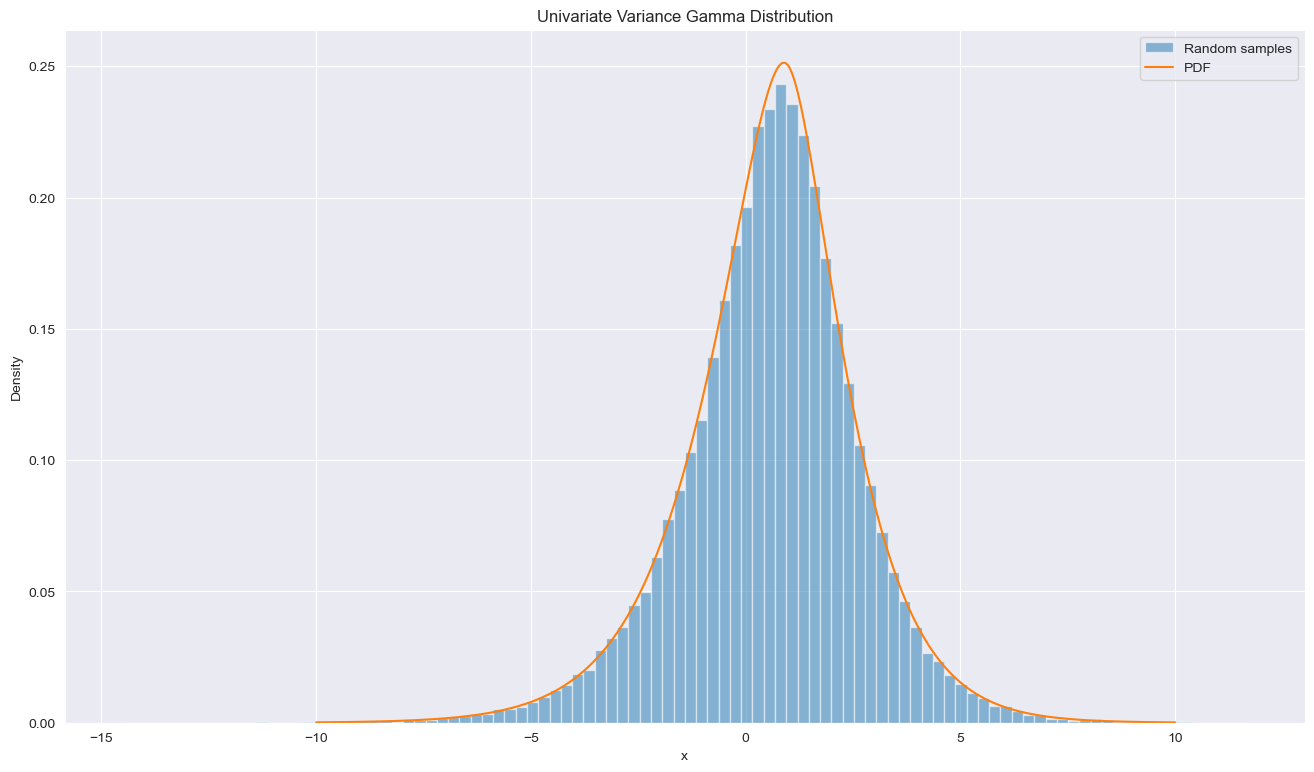

In [5]:
# Parameters for the UnivariateVarianceGamma distribution
mu = 1
alpha = 1
beta = -0.1
lam = 2

# Create an instance of the UnivariateVarianceGamma class
vg_dist = UnivariateVarianceGamma(mu, alpha, beta, lam)

# Generate random samples
sample_size = 50000
random_samples = vg_dist.rvs(size=sample_size)

print("Sample mean: {:.4f}, Actual mean: {:.4f}".format(np.mean(random_samples), vg_dist.mean()))
print("Sample variance: {:.4f}, Actual variance: {:.4f}".format(np.var(random_samples), vg_dist.var()))

# Create the plot
fig, ax = plt.subplots(figsize=(16, 9))
ax.hist(random_samples, bins=100, density=True, alpha=0.5, label='Random samples')

# Evaluate the PDF and overlay it on the histogram
x = np.linspace(-10, 10, 1000)
pdf_values = vg_dist.pdf(x)
ax.plot(x, pdf_values, label='PDF')

# Customize the plot
ax.set_xlabel('x')
ax.set_ylabel('Density')
ax.set_title('Univariate Variance Gamma Distribution')
ax.legend()
plt.show()

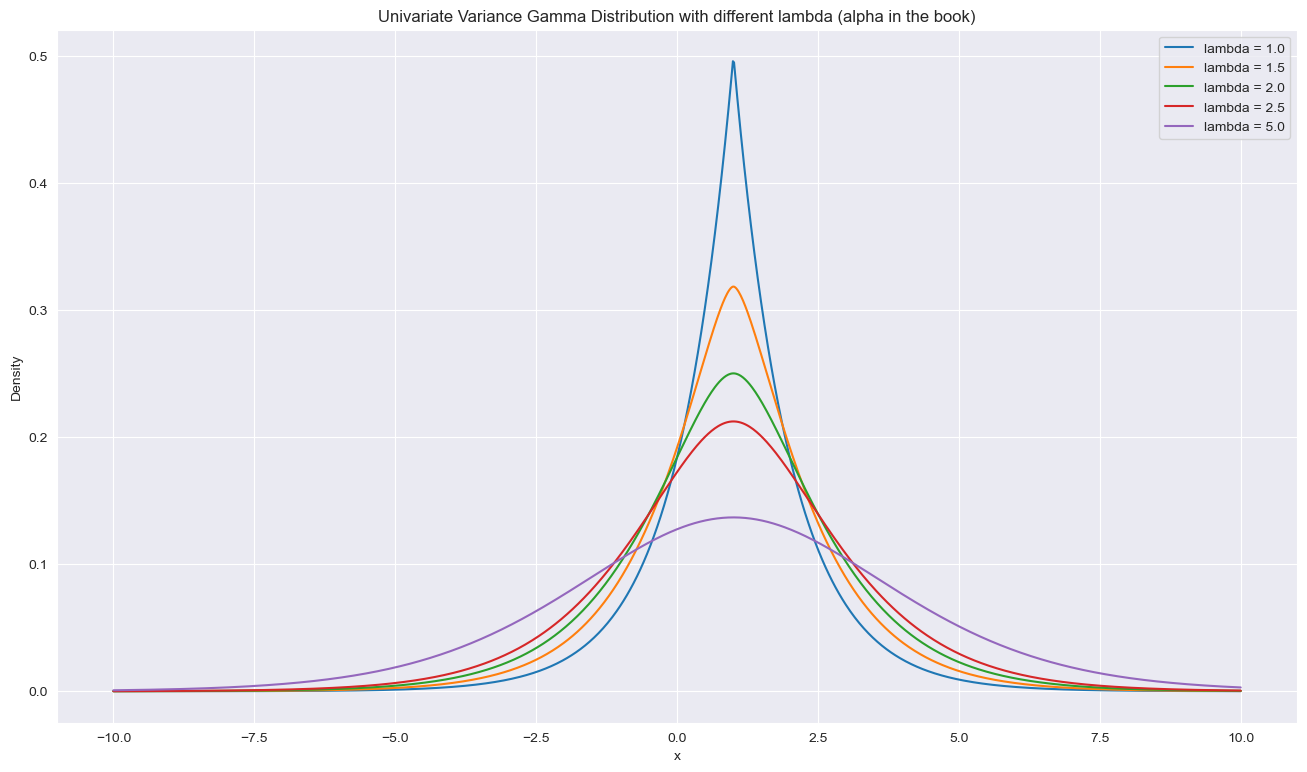

In [6]:
# Parameters for the UnivariateVarianceGamma distribution
mu = 1
alpha = 1
beta = 0
x = np.linspace(-10, 10, 1000)

# Create the plot
fig, ax = plt.subplots(figsize=(16, 9))

for lam in [1, 1.5, 2, 2.5, 5]:
    vg_dist = UnivariateVarianceGamma(mu, alpha, beta, lam)
    pdf_values = vg_dist.pdf(x)
    ax.plot(x, pdf_values, label='lambda = {:.1f}'.format(lam))

# Customize the plot
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('Density')
ax.set_title('Univariate Variance Gamma Distribution with different lambda (alpha in the book)')
plt.show()

# 4.3 the body, the shoulders, and the tails

Given a pdf with location and scale parameter
$$
p(x|\mu, \sigma) = \frac{1}{\sigma} p(\frac{x - \mu}{\sigma})
$$
its 2nd partial derivative wrt $\sigma$ is
$$
\frac{\partial^2 p(x|\mu, \sigma)}{\partial \sigma^2} = \lim_{\delta \to 0} \frac{p(x | \mu, \sigma + \delta)- 2p(x|\mu, \sigma) + p(x, \sigma - \delta)}{\delta^2} = \lim_{\delta \to 0} \frac{2(p^{\delta}(x, \sigma)-p(x|\mu, \sigma))}{\delta^2}
$$
where $p^{\delta}(x|\mu, \sigma) = (p(x|\mu, \sigma + \delta)+p(x|\mu, \sigma - \delta))/2$ is also a pdf. 

## Figure 4.4: Where do the tails start?

### normal distribution

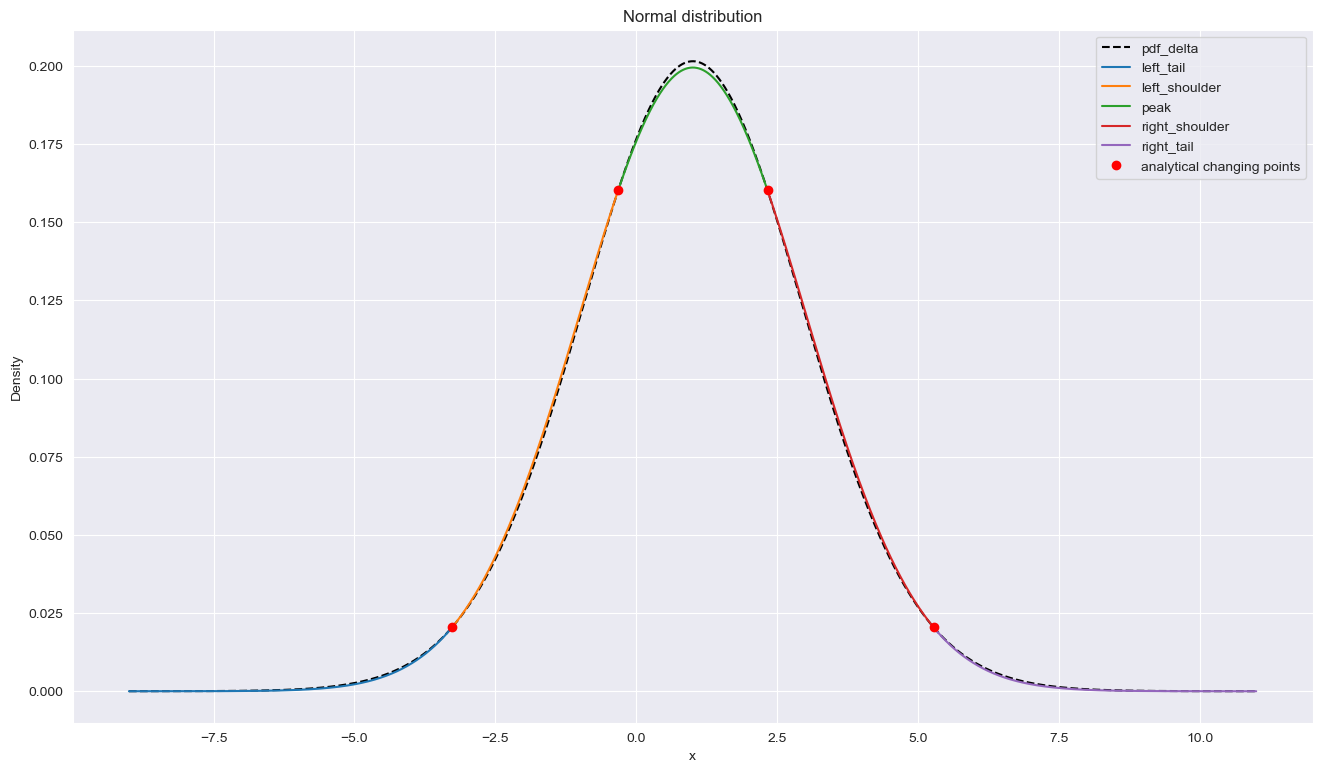

In [7]:
# Normal distribution parameters
mu = 1
sigma = 2

# Find peak, shoulder and tail of a standard normal pdf
summary = find_peak_shoulder_tail(norm.pdf, lb=mu-5*sigma, ub=mu+5*sigma, 
                                  mu=mu, sigma=sigma, dx=0.01, delta=0.1)

# Analytical values of changing points for normal distribution
a1, a2, a3, a4 = normal_peak_shoulder_tail(mu, sigma)


# Create the plot
fig, ax = plt.subplots(figsize=(16, 9))

ax.plot(summary['x'], summary['pdf_delta'], 'k--', label='pdf_delta')
for pdf_body in summary['pdf_body'].unique():
    ax.plot(summary.loc[summary['pdf_body']==pdf_body, 'x'],
            summary.loc[summary['pdf_body']==pdf_body, 'pdf'],
            label = pdf_body)
ax.plot([a1, a2, a3, a4], norm.pdf([a1, a2, a3, a4], mu, sigma), 'ro', label='analytical changing points')   

ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('Density')
ax.set_title('Normal distribution')
plt.show()

### t distribution

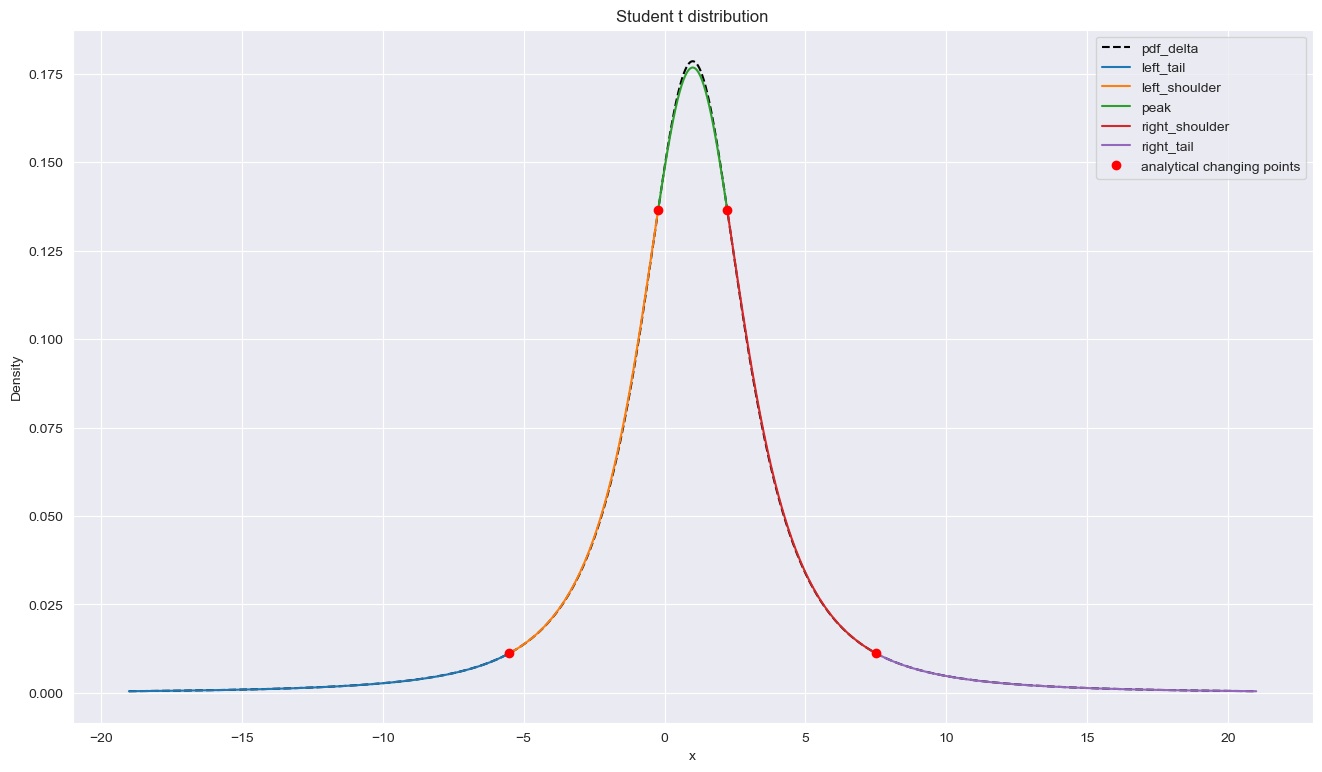

In [8]:
# Find peak, shoulder and tail of a standard normal pdf
df = 2
mu = 1
sigma = 2
summary = find_peak_shoulder_tail(lambda x: t.pdf(x, df), 
                                  mu-10*sigma, mu+10*sigma, 
                                  mu=mu, sigma=sigma, dx=0.01, delta=0.1)

# Analytical values of changing points for normal distribution
a1, a2, a3, a4 = t_peak_shoulder_tail(mu, sigma, df)

# Create the plot
fig, ax = plt.subplots(figsize=(16, 9))

ax.plot(summary['x'], summary['pdf_delta'], 'k--', label='pdf_delta')
for pdf_body in summary['pdf_body'].unique():
    ax.plot(summary.loc[summary['pdf_body']==pdf_body, 'x'],
            summary.loc[summary['pdf_body']==pdf_body, 'pdf'],
            label = pdf_body)
ax.plot([a1, a2, a3, a4], t.pdf([a1, a2, a3, a4], df, mu, sigma), 'ro', label='analytical changing points')   

ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('Density')
ax.set_title('Student t distribution')
plt.show()

# 4.4 fat tails, mean deviation and the rising norms

## Figure 4.6: The Ratio Std/MAD for the daily returns of the SP500 

[*********************100%***********************]  1 of 1 completed


Text(0, 0.5, 'SP500 STD/MAD')

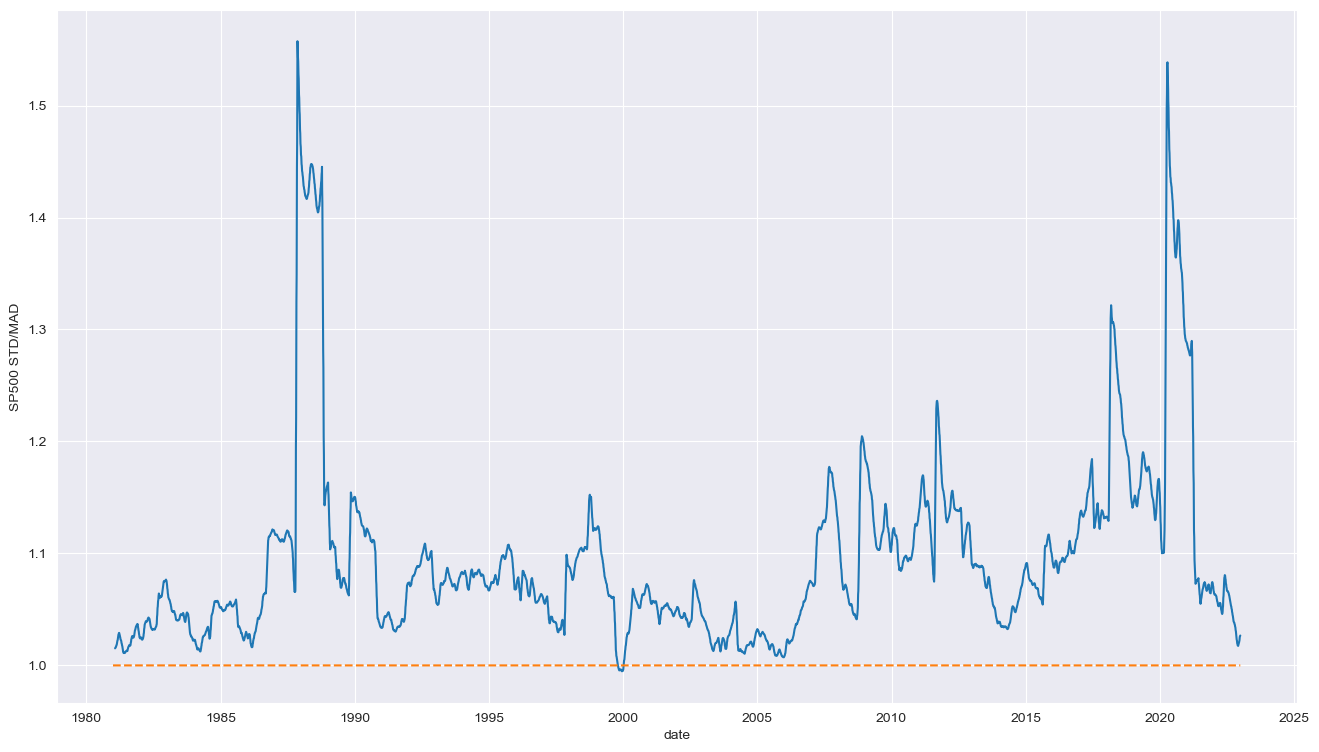

In [9]:
start_date = '1980-01-01'
end_date = '2023-01-01'
std_window = 250
rolling_window = 20

# Download SP500 data
data = yf.download('^GSPC', start=start_date, end=end_date)
sp_return = data['Adj Close'].pct_change().dropna()

# Compute std and mad (here MAD is already re-scaled to match normal std)
std = sp_return.rolling(std_window).std().dropna()
mad = sp_return.rolling(std_window).apply(mean_absolute_deviation).dropna()

fig, ax = plt.subplots(figsize=(16, 9))
ax.plot((std/mad).rolling(rolling_window).mean())
ax.plot(pd.Series(1, index=std.index), '--')
ax.set_xlabel('date')
ax.set_ylabel('SP500 STD/MAD')

## How the ratio rises

In [10]:
# Generate random numbers, including the "extreme fat tail" case in the book
n = int(1e6)
x_norm = norm.rvs(loc=0, scale=1, size=n)
x_t = t.rvs(df=3, loc=0, scale=1, size=n)
x_cauchy = cauchy.rvs(loc=0, scale=1, size=n)
x_vg = UnivariateVarianceGamma(0, 1, 0, 0.5).rvs(n)
x_extreme = np.ones(n)
x_extreme[0] = 1e6

### Std - mean absolute deviation ratio
Note: in my function the mean absolute deviation is already adjusted to match normal std

In [11]:
print('Normal std -  mean absolute deviation ratio: {:.2f}'.format(np.std(x_norm)/mean_absolute_deviation(x_norm)))
print('Variance Gamma std -  mean absolute deviation ratio: {:.2f}'.format(np.std(x_vg)/mean_absolute_deviation(x_vg)))
print('Student t std -  mean absolute deviation ratio: {:.2f}'.format(np.std(x_t)/mean_absolute_deviation(x_t)))
print('Cauchy std -  mean absolute deviation ratio: {:.2f}'.format(np.std(x_cauchy)/mean_absolute_deviation(x_cauchy)))
print('Extreme example std -  mean absolute deviation ratio: {:.2f}'.format(np.std(x_extreme)/mean_absolute_deviation(x_extreme)))

Normal std -  mean absolute deviation ratio: 1.00
Variance Gamma std -  mean absolute deviation ratio: 1.25
Student t std -  mean absolute deviation ratio: 1.26
Cauchy std -  mean absolute deviation ratio: 81.47
Extreme example std -  mean absolute deviation ratio: 398.94


### Std - median absolute deviation ratio
The "extrem fat tail" example's median absolute deviation is zero, since median related metrics would ignore the outlier. It is more robust than mean absolute deviation, but might be too robust in some usecases.

In [12]:
print('Normal std -  median absolute deviation ratio: {:.2f}'.format(np.std(x_norm)/median_absolute_deviation(x_norm)))
print('Variance Gamma std -  median absolute deviation ratio: {:.2f}'.format(np.std(x_vg)/median_absolute_deviation(x_vg)))
print('Student t std -  median absolute deviation ratio: {:.2f}'.format(np.std(x_t)/median_absolute_deviation(x_t)))
print('Cauchy std -  median absolute deviation ratio: {:.2f}'.format(np.std(x_cauchy)/median_absolute_deviation(x_cauchy)))
print('Extreme example std -  median absolute deviation ratio: {:.2f}'.format(np.std(x_extreme)/median_absolute_deviation(x_extreme)))

Normal std -  median absolute deviation ratio: 1.00
Variance Gamma std -  median absolute deviation ratio: 1.85
Student t std -  median absolute deviation ratio: 1.54
Cauchy std -  median absolute deviation ratio: 663.40
Extreme example std -  median absolute deviation ratio: inf


C:\Users\soars\AppData\Local\Temp\ipykernel_45100\3348066855.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  print('Extreme example std -  median absolute deviation ratio: {:.2f}'.format(np.std(x_extreme)/median_absolute_deviation(x_extreme)))


## Figure 4.8: A simulation of the Relative Efficiency ratio

Here we also evaluated the median absolute deviation for the normal distribution with random variance. $a$ is the parameter of tail thickness. Based on the numerical simulation, we find:
* mean absolute deviation is less efficient than std when a<3
* median absolute deviation is less efficient than std when a<11
* median absolute deviation is less efficient than mean absolute deviation when a<65

Text(0, 0.5, 'approximate relative efficiency ratio')

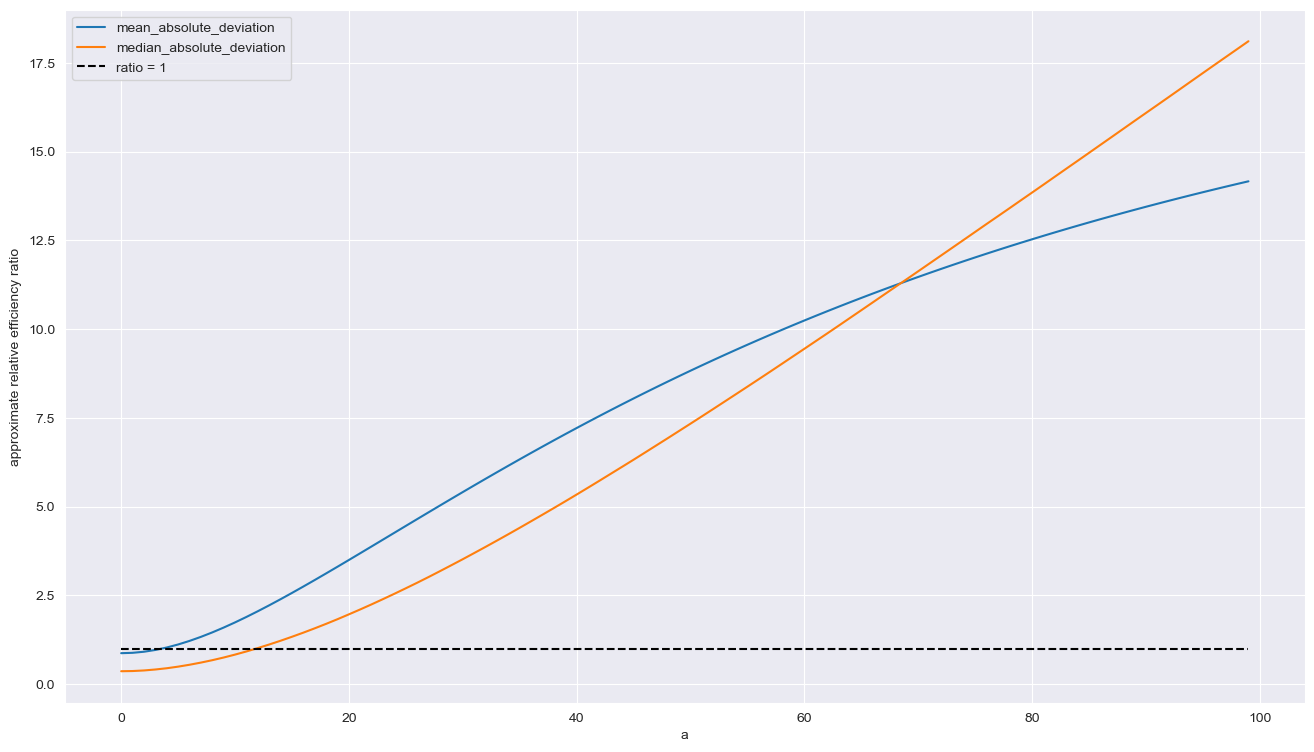

In [13]:
m = 10000 # std/mad sample size
n = 1000 # sample size for computing std/mad
p = 0.01

# generate random numbers
v = np.random.rand(m, n)
v = (v<p).astype(int)
z = norm.rvs(size=(m, n))

# compute approximate relative efficiency ratio
are = pd.DataFrame(columns=['mean_absolute_deviation', 'median_absolute_deviation'], dtype=float)
                   
for a in np.arange(0, 100, 1):
    # normal with random variance
    x = np.sqrt(a*v+1)*z
    
    # std simulation efficiency
    std = np.std(x, axis=1)
    std_eff = np.var(std) / np.mean(std)
    
    # mean absolute deviation simulation efficiency
    mean_ad = mean_absolute_deviation(x, axis=1)
    mean_ad_eff = np.var(mean_ad) / np.mean(mean_ad)
                   
    # median absolute deviation simulation efficiency
    median_ad = median_absolute_deviation(x, axis=1)
    median_ad_eff = np.var(median_ad) / np.mean(median_ad)
    
    # std/mad efficicency ratio
    are.loc[a, 'mean_absolute_deviation'] = std_eff / mean_ad_eff
    are.loc[a, 'median_absolute_deviation'] = std_eff / median_ad_eff
        

# Create the plot
fig, ax = plt.subplots(figsize=(16, 9))
are.plot(ax=ax)
ax.plot(are.index, np.ones(are.shape[0]),  'k--', label='ratio = 1')
ax.legend()
ax.set_xlabel('a')
ax.set_ylabel('approximate relative efficiency ratio')

## Figure 4.9 - 4.10: Histograms of Std and MAD

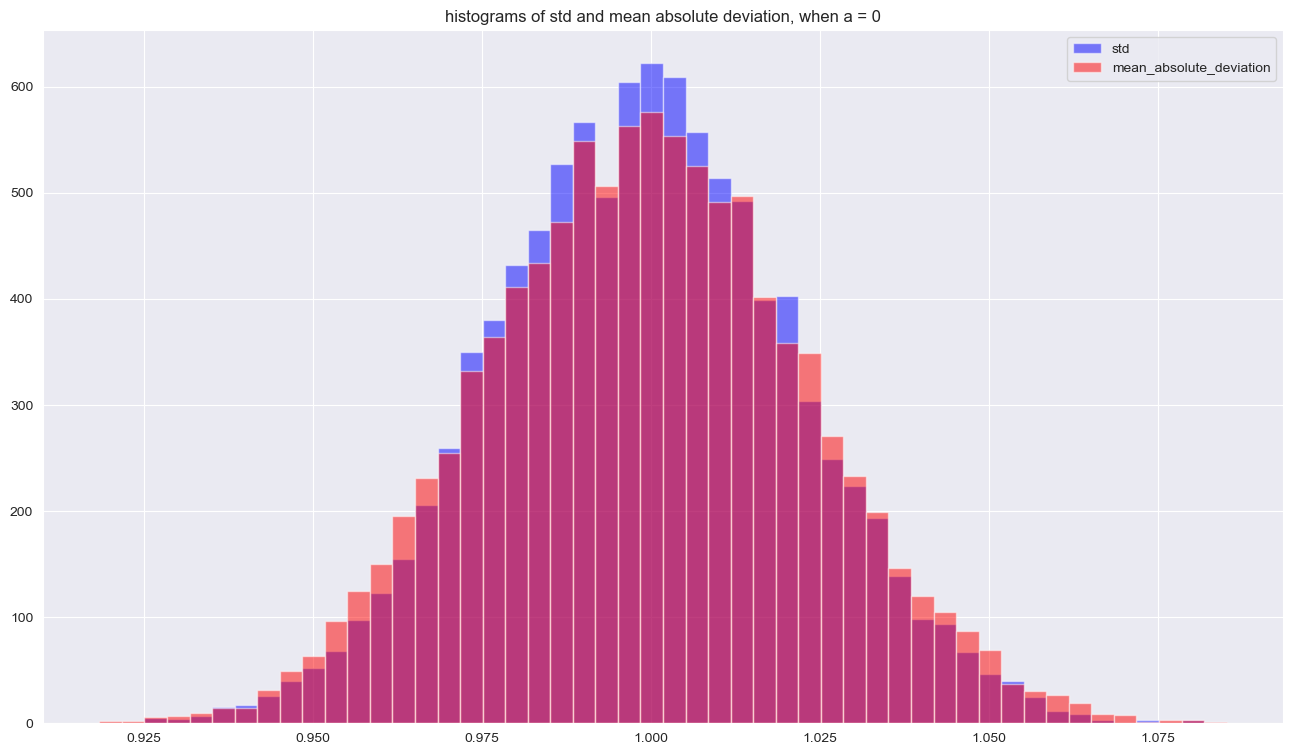

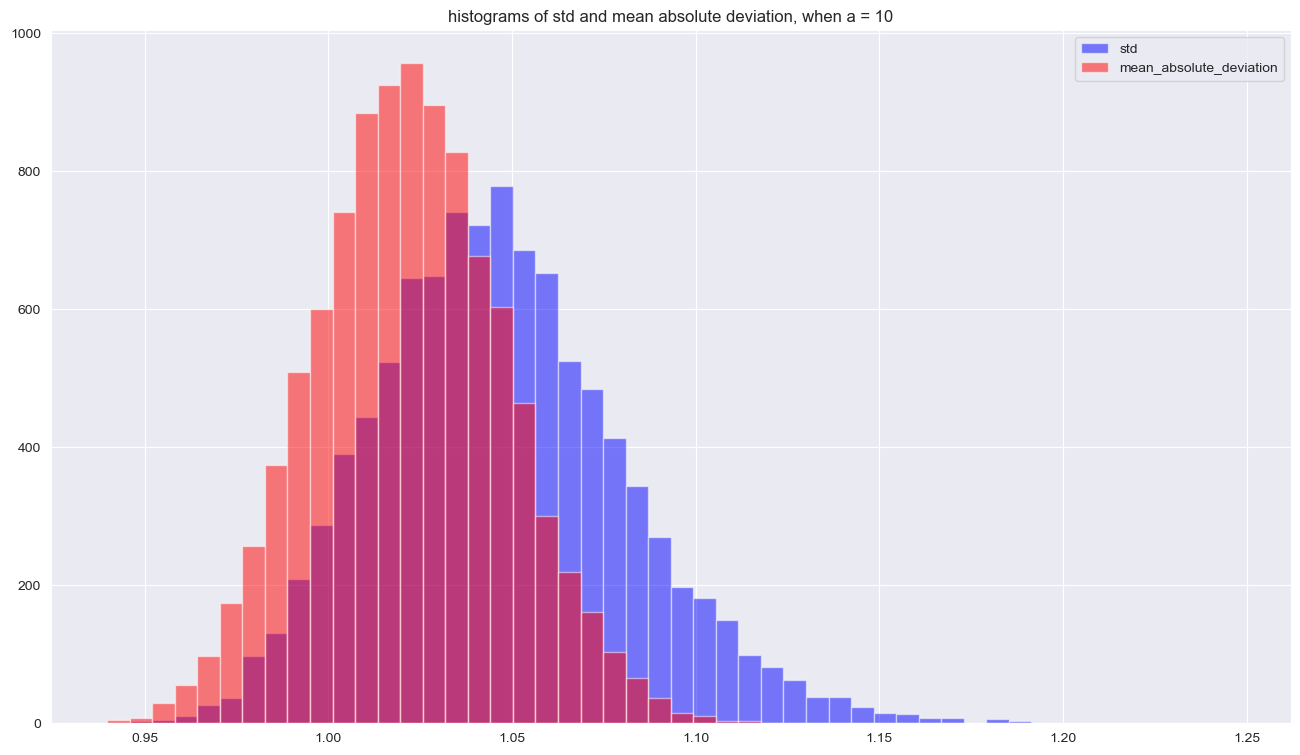

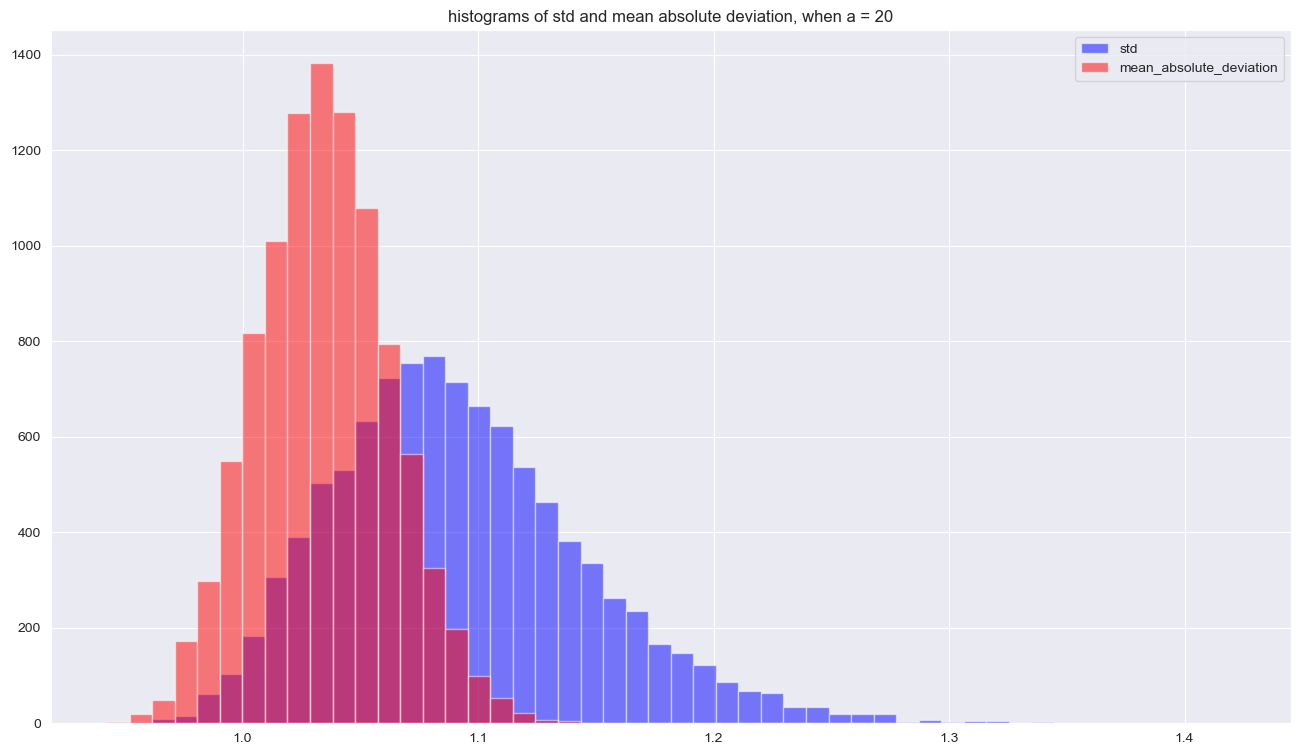

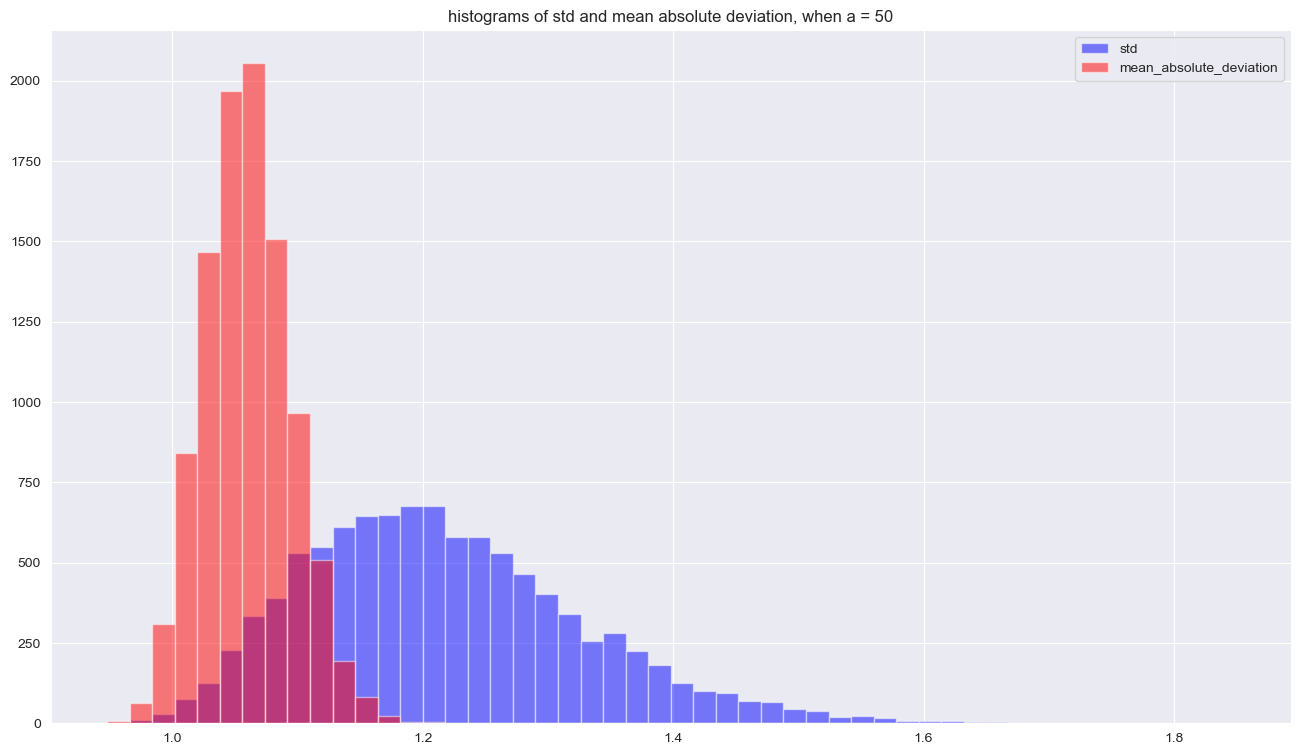

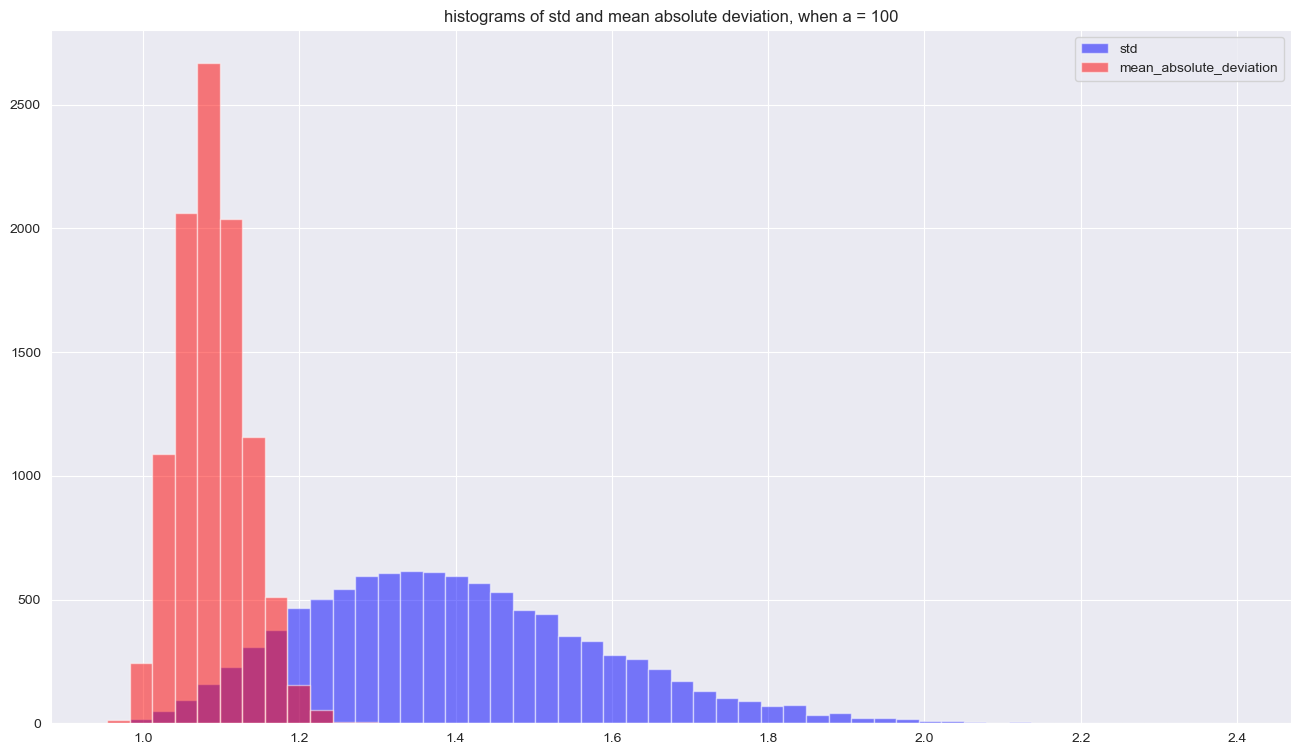

In [14]:
m = 10000 # std/mad sample size
n = 1000 # sample size for computing std/mad
p = 0.01

# generate random numbers
v = np.random.rand(m, n)
v = (v<p).astype(int)
z = norm.rvs(size=(m, n))

for a in [0, 10, 20, 50, 100]:
    # normal with random variance
    x = np.sqrt(a*v+1)*z
    
    # std and mad simulation
    std = np.std(x, axis=1)
    mean_ad = mean_absolute_deviation(x, axis=1)
    
    # generate figures
    fig, ax = plt.subplots(figsize=(16, 9))
    compare_histograms(std, mean_ad, ax, bins=50)
    ax.legend(['std', 'mean_absolute_deviation'])
    ax.set_title('histograms of std and mean absolute deviation, when a = {}'.format(str(a)))

## Figure 4.11 - 4.12: The sample mean and variance of Cauchy distribution

Text(0, 0.5, 'sample variance')

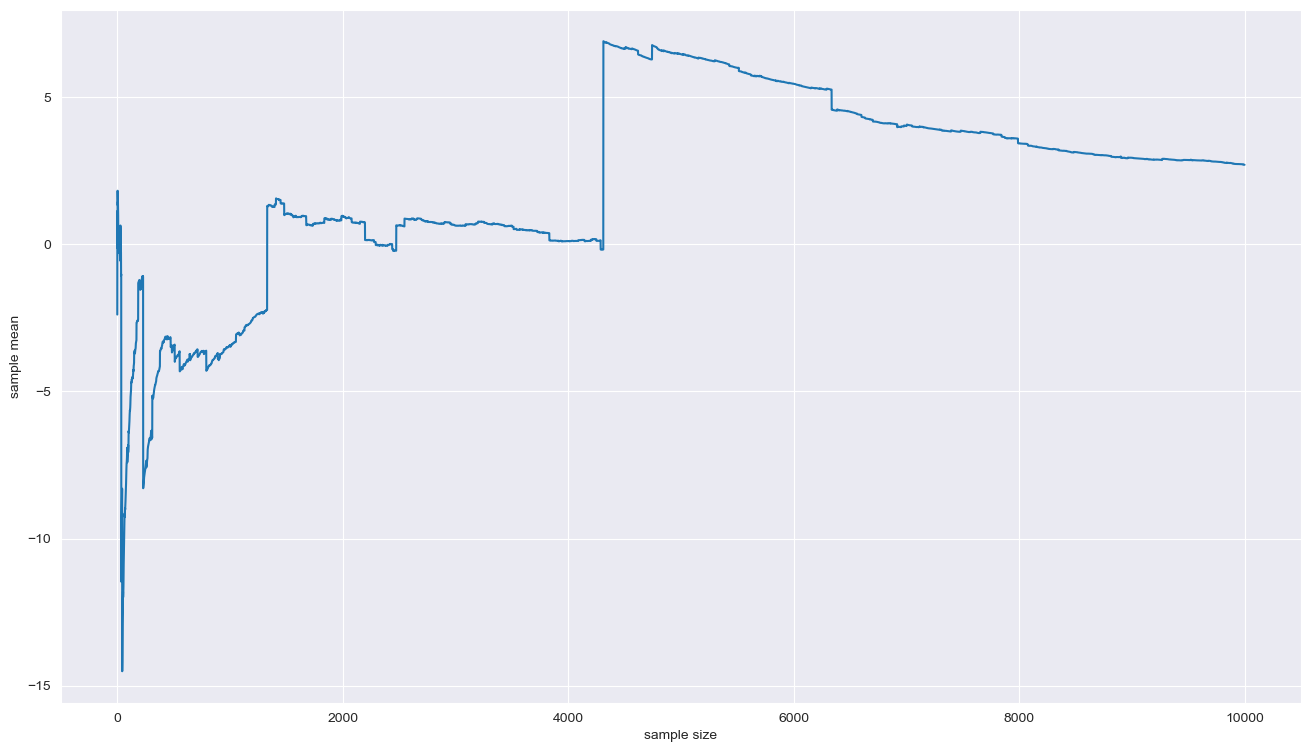

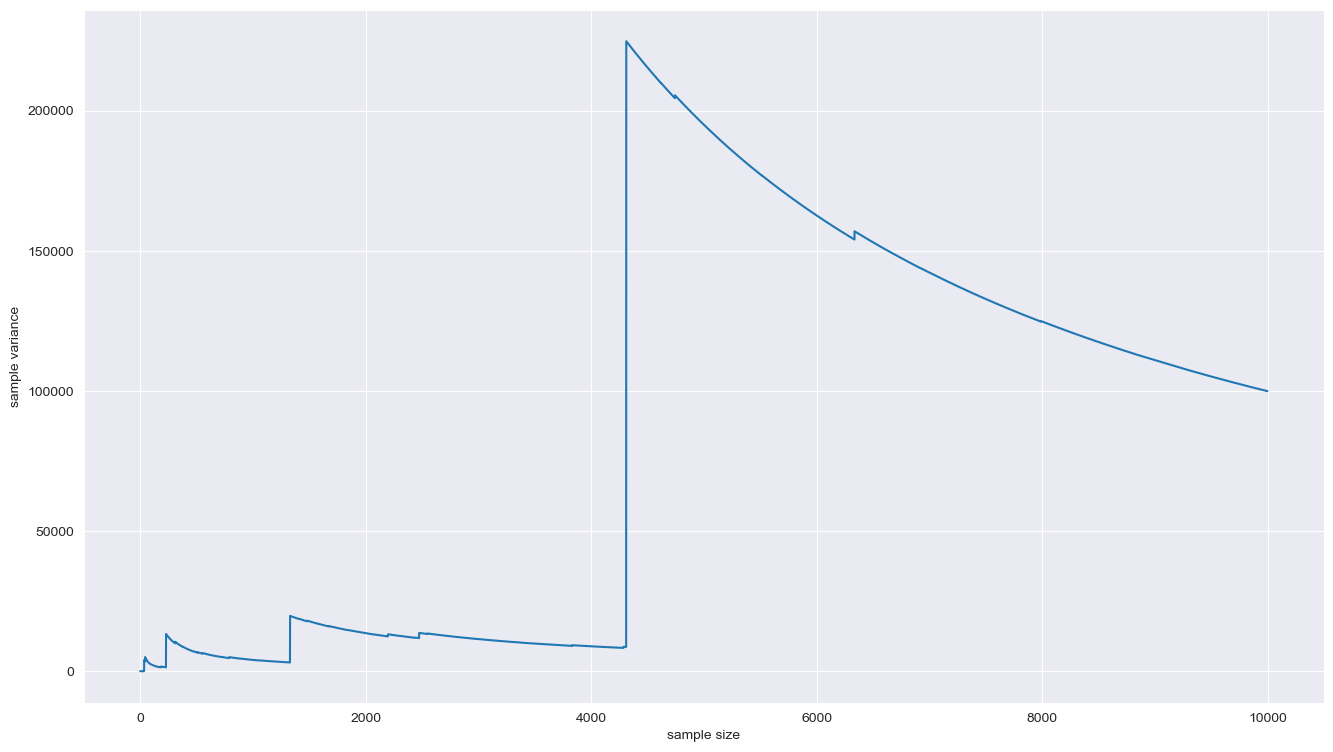

In [15]:
n = 10000
x = cauchy.rvs(0, 2, n, random_state=5)

cum_mean = np.cumsum(x)/np.arange(1, n+1)
cum_var = np.cumsum(x**2)/np.arange(1, n+1) - cum_mean**2

fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(cum_mean)
ax.set_xlabel('sample size')
ax.set_ylabel('sample mean')

fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(cum_var)
ax.set_xlabel('sample size')
ax.set_ylabel('sample variance')

## Figure 4.14: Rising norms and the unit cube

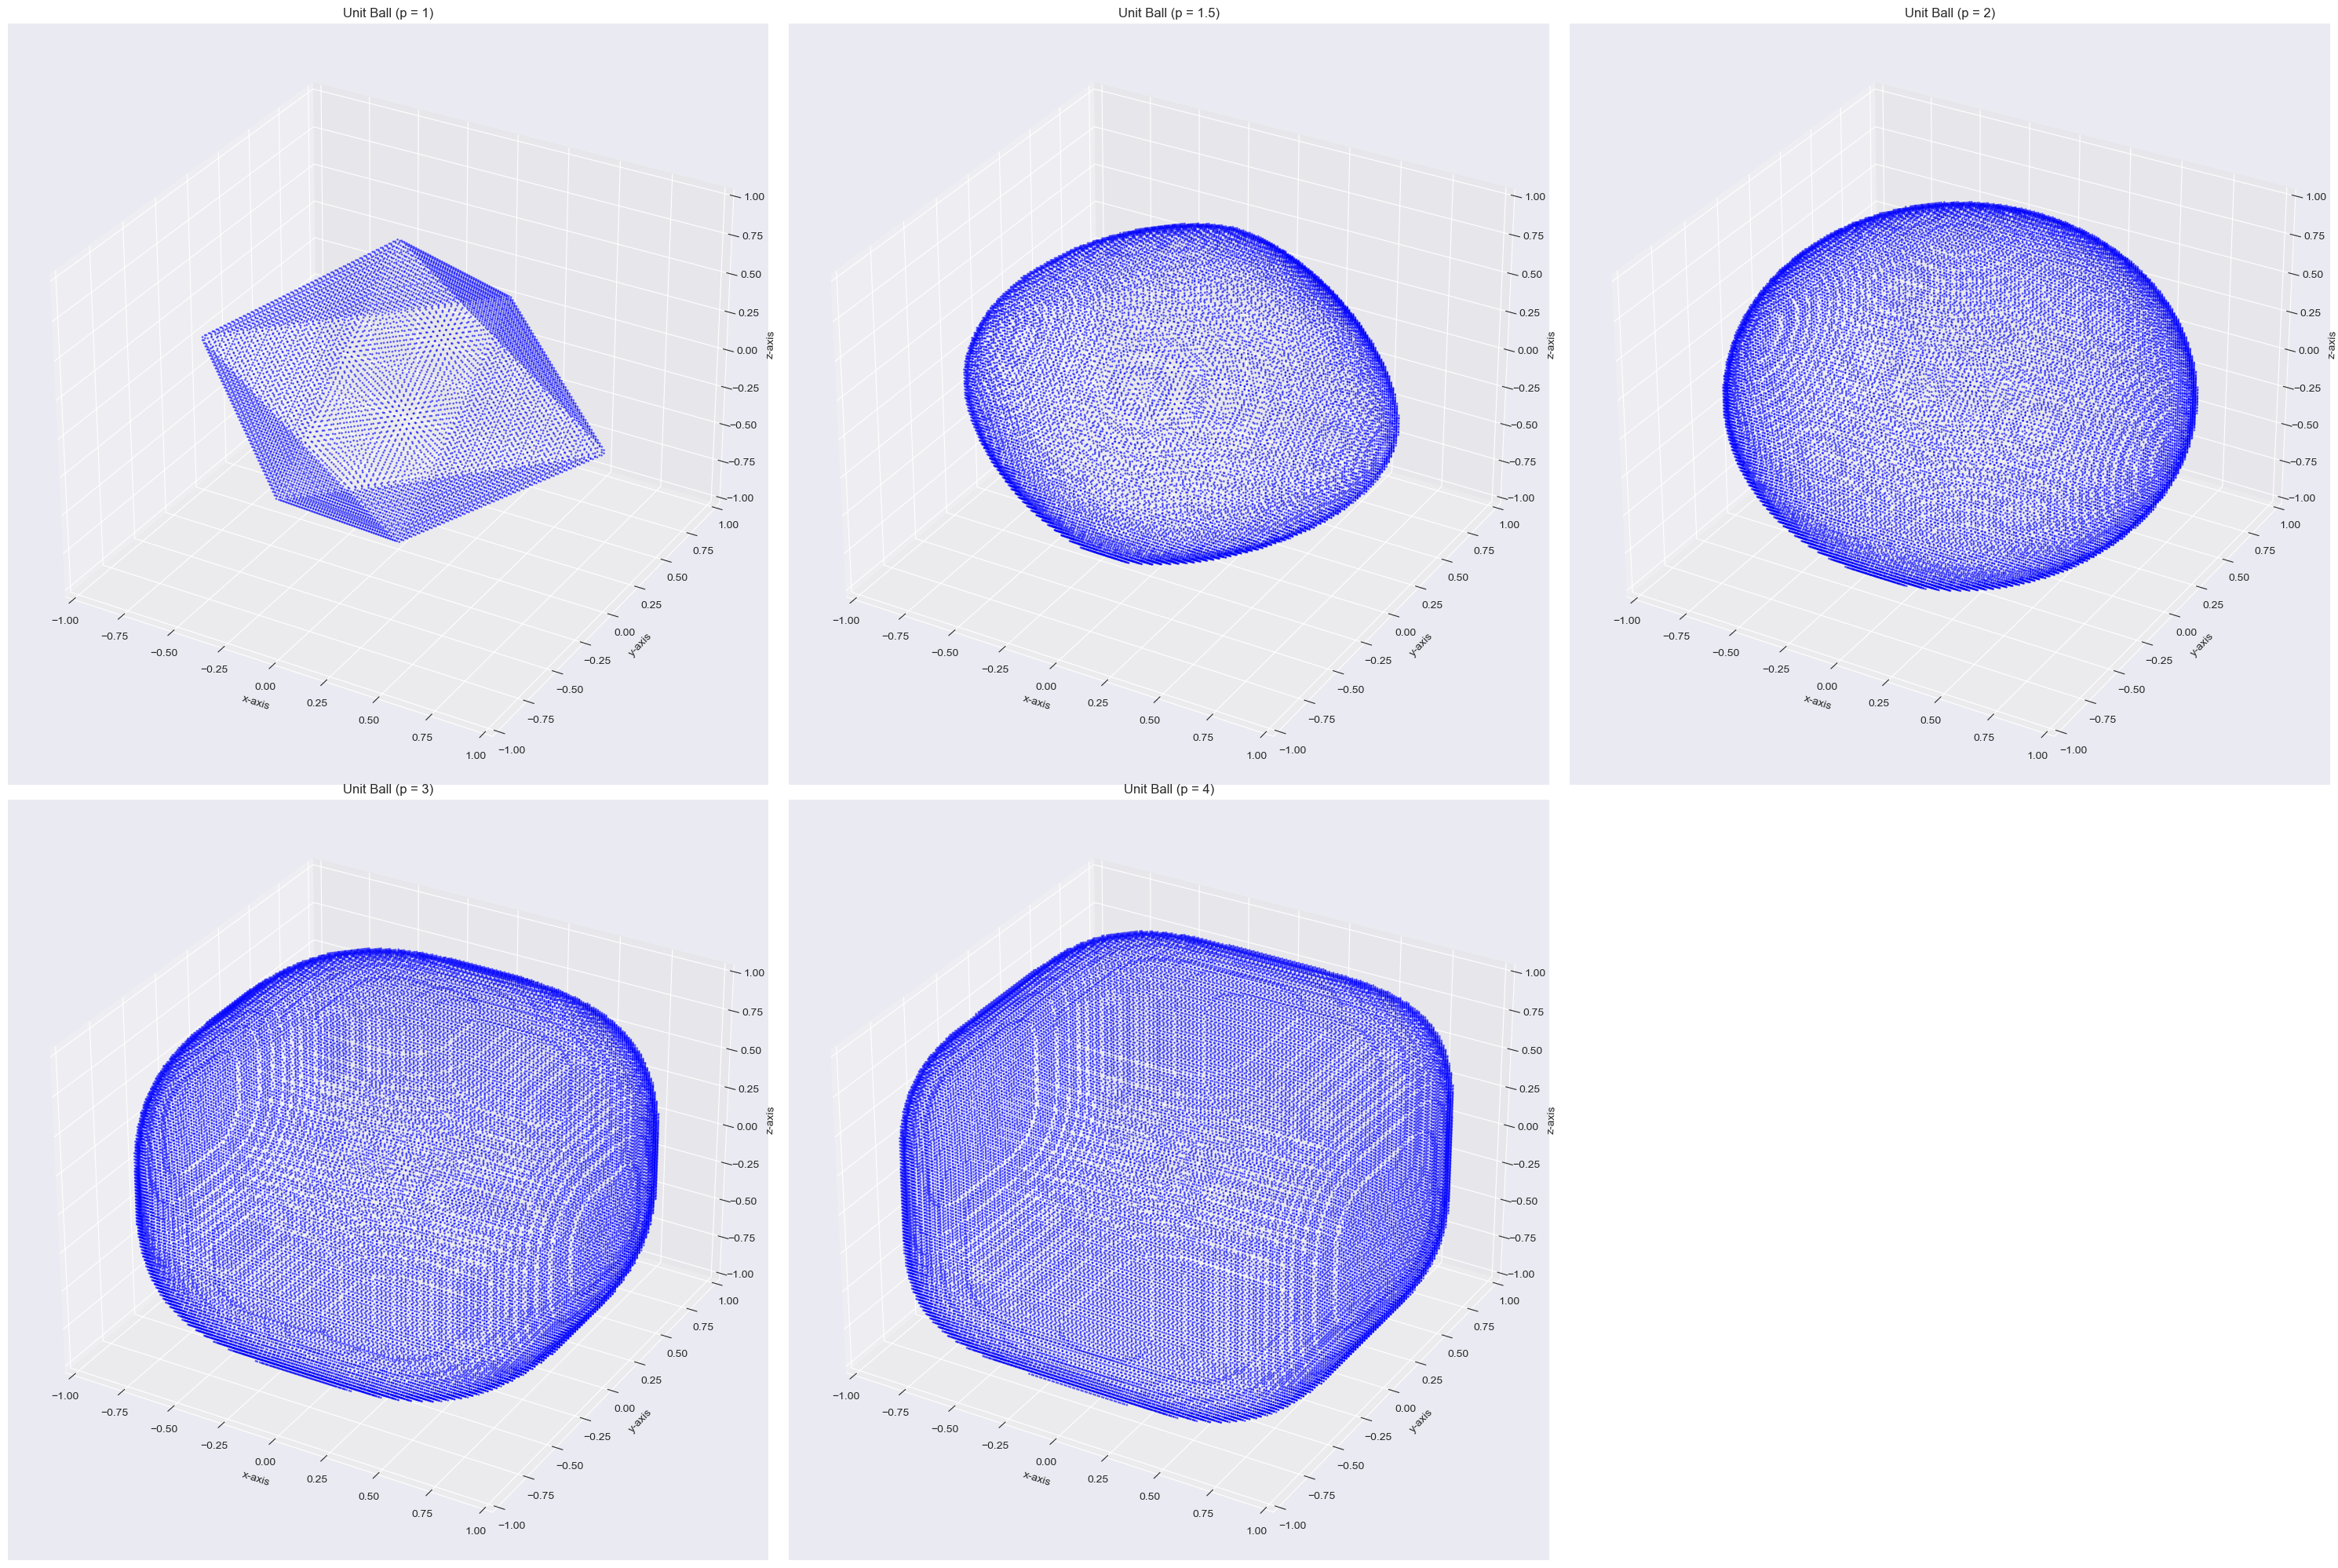

In [16]:
# Define the p-norm function
def p_norm(x, y, z, p):
    return (np.abs(x)**p + np.abs(y)**p + np.abs(z)**p)**(1/p)

# Generate a meshgrid for plotting
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
z = np.linspace(-1, 1, 100)
X, Y, Z = np.meshgrid(x, y, z)

# List of p values
p_values = [1, 1.5, 2, 3, 4]

# Create a 3D plot for each p value
fig = plt.figure(figsize=(30, 20))

for i, p in enumerate(p_values):
    norm = p_norm(X, Y, Z, p)
    mask = np.isclose(norm, 1, rtol=1e-2)  # rtol determines the tolerance for considering values close to 1
    
    ax = fig.add_subplot(2, 3, i+1, projection='3d')
    ax.scatter(X[mask], Y[mask], Z[mask], c='blue', alpha=0.5, s=1)
    ax.set_title(f'Unit Ball (p = {p})')
    ax.set_xlabel('x-axis')
    ax.set_ylabel('y-axis')
    ax.set_zlabel('z-axis')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(-1, 1)

plt.tight_layout()
plt.show()